# Auto-regression of Covid-19 cases per department (France)

In [2]:
import os
import json
import numpy as np
import pandas as pd
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model

## Read Data

Data from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/

I reorganised data; one column per department. Numbers are 'incid_hosp' in the original file - representing daily incidence numbers. That's our prediction target (although it would be interesting to test other targets and compare these numbers to other variables and files provided, such as 'sursauds').

In [3]:
data = pd.read_csv(os.path.join('.', 'data', 'incidences.csv'), index_col=0)
data.head(3)

,01,02,03,04,05,06,07,08,09,10,...,91,92,93,94,95,971,972,973,974,976
date,,,,,,,,,,,,,,,,,,,,,
2020-03-19,1,38,3,1,4,12,7,1,0,6,...,49,94,104,115,79,0,1,0,0,0
2020-03-20,0,10,4,0,2,22,7,0,1,2,...,40,65,44,66,61,0,2,0,0,0
2020-03-21,3,30,5,1,3,5,6,2,1,6,...,37,100,51,57,70,0,0,0,0,0


In [4]:
data.shape

(35, 101)

We will to a simple regregression model per department as a baseline. Data starts at '2020-03-19'. We have 35 points (update with more) per department. This is not much and fitting powerful models is likely to fail. We will use a simple cross-validations scheme, where we shall train on date < '2020-04-08' and test on remaining data.

In France, lockdown has started at '2020-03-16', if we assume that it has shown its effect in observed cases starting 14 days later, we would see that effect starting from '2020-04-01'. Adding one more week for the incubation period of new cases within the new dynamics, puts us at our 'split date' ('2020-04-08') for our cross-validation scheme.

In [5]:
dates =  data.index
split = '2020-04-08'

## Create lag features

We will create a data structure per department, where we will have incidence data

In [6]:
lags = range(1, 7)  # consider last 7 days
feat_app = []
for col in data.columns:
    df_dept = pd.DataFrame(data[col],columns = [col], index = dates)
    df_dept.index = pd.to_datetime(df_dept.index)
    df_dept = df_dept.assign(**{
        't-{}'.format(t): df_dept[col].shift(t)
    for t in lags
    })
    #featured = featured.merge(df_dept, how='left', left_index = True, right_index = True)
    df_dept.dropna(axis=0,inplace=True)
    feat_app.append([col,df_dept])
    

In [7]:
feat_app

[['01',             01   t-1   t-2   t-3   t-4   t-5   t-6
  date                                              
  2020-03-25  12  11.0  14.0   3.0   3.0   0.0   1.0
  2020-03-26  13  12.0  11.0  14.0   3.0   3.0   0.0
  2020-03-27  15  13.0  12.0  11.0  14.0   3.0   3.0
  2020-03-28   7  15.0  13.0  12.0  11.0  14.0   3.0
  2020-03-29  10   7.0  15.0  13.0  12.0  11.0  14.0
  2020-03-30  19  10.0   7.0  15.0  13.0  12.0  11.0
  2020-03-31  20  19.0  10.0   7.0  15.0  13.0  12.0
  2020-04-01  38  20.0  19.0  10.0   7.0  15.0  13.0
  2020-04-02  33  38.0  20.0  19.0  10.0   7.0  15.0
  2020-04-03  14  33.0  38.0  20.0  19.0  10.0   7.0
  2020-04-04  25  14.0  33.0  38.0  20.0  19.0  10.0
  2020-04-05  10  25.0  14.0  33.0  38.0  20.0  19.0
  2020-04-06  10  10.0  25.0  14.0  33.0  38.0  20.0
  2020-04-07  14  10.0  10.0  25.0  14.0  33.0  38.0
  2020-04-08  18  14.0  10.0  10.0  25.0  14.0  33.0
  2020-04-09  13  18.0  14.0  10.0  10.0  25.0  14.0
  2020-04-10  18  13.0  18.0  14.0  10.0

Following function will fit a model to a given dataframe, given the CV logic above, and return an augmented data frame containing predictions in a new column. I have experimented with Lasso and other linear models, with not much difference compared to random forests with various parameters.
An even better approach, to be able to obtain better baselines, might be to fit polynoms on Xs, before fitting predictors (TODO).

In [8]:

def fit_one(dept_name, dept, split, dates):
    train = dept[dept.index < split].copy()
    #print (len(train))
    val = dept[dept.index >= split].copy()

    xtr, xts = train.drop([dept_name], axis=1), val.drop([dept_name], axis=1)
    ytr, yts = train[dept_name].values, val[dept_name].values

    #clf = linear_model.Lasso(alpha=0.5)
    #clf.fit(xtr, ytr)
    clf = RandomForestRegressor(n_estimators=20,max_depth=5, n_jobs=-1, random_state=0)
    clf.fit(xtr, ytr)
    p = clf.predict(xts)

    error = mean_absolute_error(yts, p)
    #print('Mean Error for',dept_name,' is ', error )
    
    aug_dept = dept.copy()
    aug_dept['preds'] = '' 
    aug_dept['preds'][dept.index < split] = ytr
    aug_dept['preds'][dept.index >= split] =  p
   
    return aug_dept

In [9]:
scores = []
aug_feat_app =  []
for [col, df] in feat_app:
    #print(col, df.columns[0])
    #print first and last date
    #print split date, sample size for train and test
    #print ('Starting ...',col )
    df2 = fit_one(col,df,split,dates)
    aug_feat_app.append([col, df2])
    true_labels = df2[df2.index >= split]['{}'.format(col)]
    predicted = df2[df2.index >= split]['preds']
    sum_error = np.sum(np.abs(true_labels-predicted))
    l = len(predicted)
    scores.append([col,round(mean_absolute_error(true_labels,predicted),2), true_labels.sum()])
    #print (col, 'Error: ', round(mean_absolute_error(true_labels,predicted),2),'sum: ', true_labels.sum(), '% : ', round(mean_absolute_error(true_labels,predicted)/ true_labels.sum(),2))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

In [10]:
#cumulative sum is after split date, as well as relative err
scores =  pd.DataFrame(scores, columns = ['dept','MAE','c_sum'])
scores.sort_values('MAE', inplace=True, ascending = False)
#scores =scores.reset_index()
scores['relative_misses'] = scores['MAE'] / scores['c_sum']
scores = scores.drop(48, axis=0) # dept 48 has 0 cases, drop it do divide

In [11]:
scores = scores.reset_index()

In [12]:
print('mean error',scores.MAE.mean())
print('max relative error',scores.relative_misses.max())

mean error 16.56830000000001
max relative error 0.895


In [13]:
scores = scores.sort_values('c_sum', ascending = False)
scores

,index,dept,MAE,c_sum,relative_misses
0,75,75,157.60,2523,0.062465
5,93,93,59.95,1846,0.032476
1,94,94,97.09,1832,0.052997
2,92,92,86.33,1686,0.051204
12,12,13,34.26,1289,0.026579
21,77,77,22.58,1156,0.019533
7,69,69,47.08,1108,0.042491
9,95,95,39.20,1049,0.037369
10,91,91,38.09,1044,0.036485
14,59,59,29.94,939,0.031885


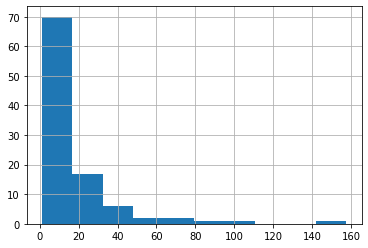

In [14]:
scores.MAE.hist()

# Notes

The regression models are good in most cases. For about 70 departments, about ~10day per day are missed. For top 10 departments where the cumulative incidence (c_sum) is the highest the relative misses are below 5%. The top 4 departments where the relative misses are above 20% have few cases (thus, large variance).

Generally, these auto-regressive models are good; and they constitute a good baseline to compare against mobility based models or aggregate models.

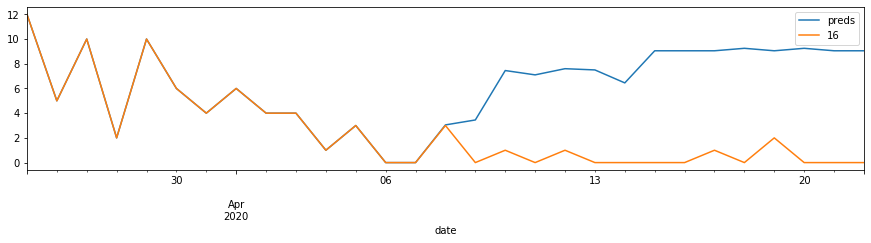

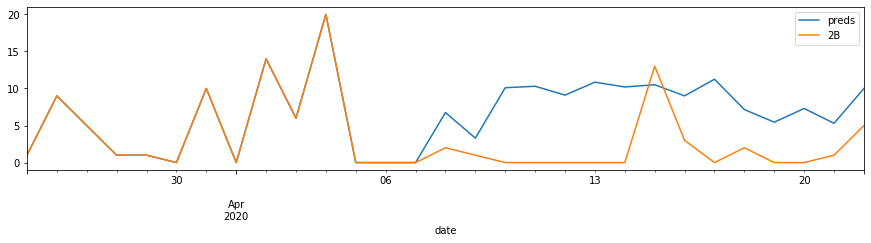

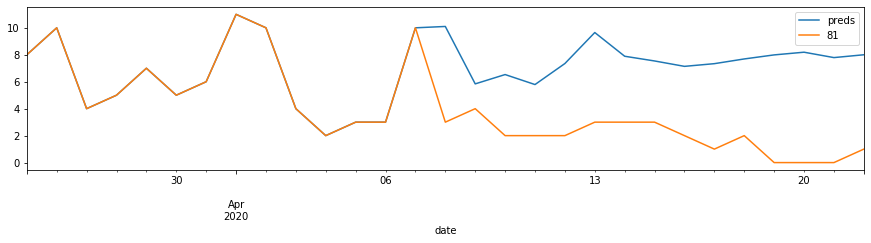

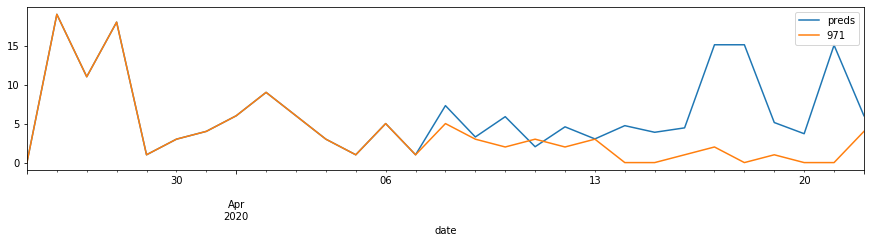

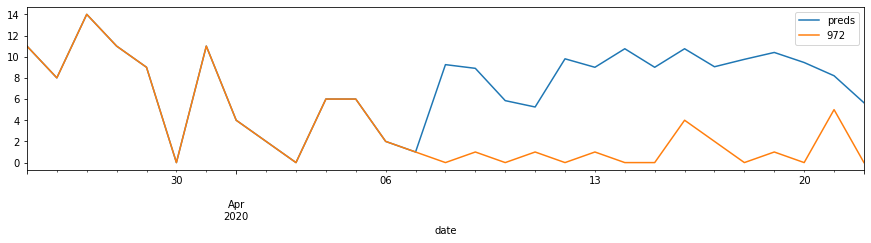

In [62]:
worst_depts = ['16', '972', '2B', '81', '971']
for col, dept in aug_feat_app:
    if col in worst_depts:
        dept[['preds',col]].plot(figsize=(15,3))
  

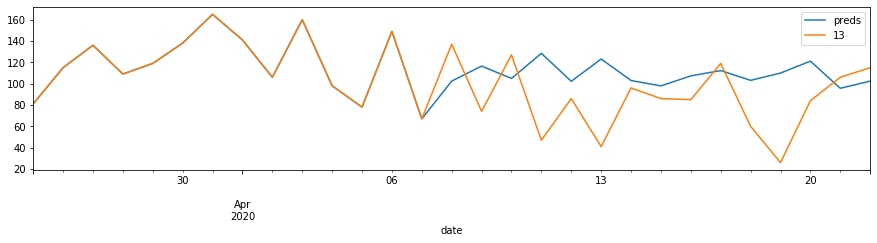

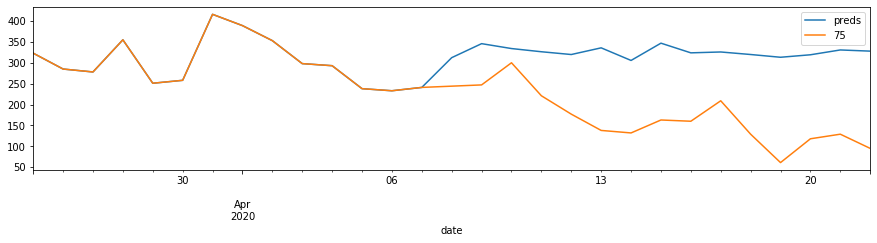

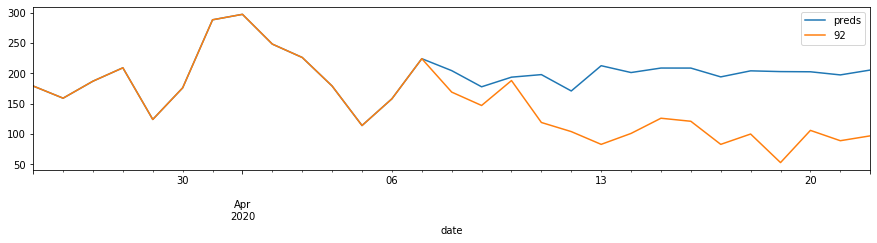

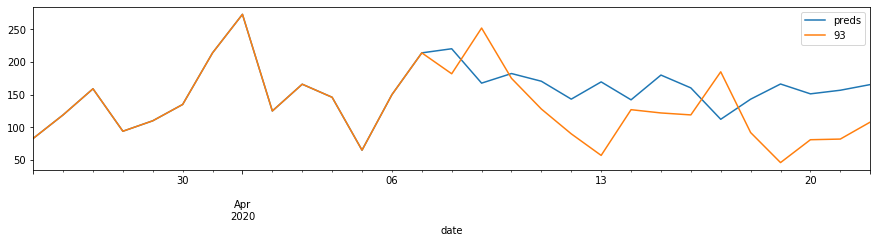

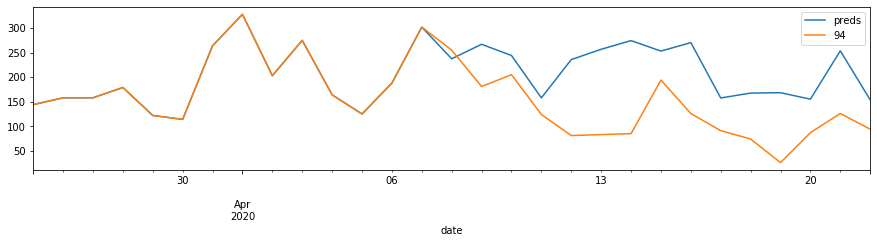

In [90]:
most_affected = ['75', '93', '94', '92', '13']
for col, dept in aug_feat_app:
    if col in most_affected:
        dept[['preds',col]].plot(figsize=(15,3))